###### Advanced Physiology
# Analyse de données de séquençage d’ARNm sur des cellules uniques. Identification de sous-populations cellulaires.
### Modalité d’évaluation : rédaction d’un rapport
### Durée du projet :
6 semaines de mi-octobre à fin novembre (flexible).
Déroulement du projet : planifier ~3 rendez-vous de 20 minutes à 2 semaines d’intervalle.
### Ressources (conseillées) :
https://hemberg-lab.github.io/scRNA.seq.course/introduction-to-rbioconductor.html

http://dridk.me/sc-rna-seq.html
### Introduction
Le projet proposé reproduit une partie des analyses effectuées dans le cadre d’un projet de recherche en cours. Les données ne doivent pas être diffusées, ni être mises en ligne.
On s’intéresse aux facteurs génétiques contrôlant les déformations d’un tissu épithélial chez la drosophile (Drosophila Melanogaster). Pour cela, on mesure le transcriptome (expression des ARN messagers) sur cellules uniques à des temps très précis du développement (juste avant et juste après une vague de divisions cellulaires). L’objectif est d’identifier les gènes contrôlant cette prolifération.
Lors de la collecte des cellules à séquencer, le biologiste ne peut pas disséquer le tissu épithélial seul, mais prélève également des cellules venant de tissues connexes (muscle, tendon, neurones). Une étape cruciale de l’analyse est donc d’identifier a posteriori, à l’aide d’analyses bioinformatiques, le type cellulaire. On se propose de reproduire ici cette étape de l’analyse. Le projet doit être réalisé en Python.
### Projet
Si vous souhaitez allez plus loin et utiliser ces données pour de la modélisation, n’hésitez pas à me le préciser.

----

## Data Filtration
### 1) Data : Descriptive Analysis
* Loading libraries

In [2]:
import numpy as np     # https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf
import pandas as pd     # https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.sandbox.stats.multicomp as sm
from timeit import default_timer as timer
from tabulate import tabulate
import scprep

* Loading and displaying data

In [3]:
start = timer()

#df = pd.read_table('counting_matrix', sep=';', header=0, index_col=0)  # https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
df = pd.read_table('data.txt', sep=',', header=0, index_col=0)  # https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
cellnames = list(df.columns.values)
genenames = list(df.index.values)

print(df)
#print(cellnames)
#print(genenames)
print("Elapsed time (in seconds) = ", timer() - start)

         AAACCCAAGAACTGAT  AAACCCAAGGGAGGGT  AAACCCAAGTCACAGG  \
CG15322                 1                 0                 0   
CG33217                 2                 0                 0   
Vps11                   4                 0                 0   
RpL10                 468                15                10   
G9a                    13                 0                 0   
...                   ...               ...               ...   
Pino                    3                 0                 1   
CG4629                  0                 0                 0   
S                      16                 0                 0   
CG2839                  0                 0                 0   
Nnf1b                   1                 0                 0   

         AAACCCAAGTCGCCCA  AAACCCACAGGTGTGA  AAACCCACATAATCCG  \
CG15322                 0                 0                 0   
CG33217                 1                 0                 0   
Vps11                   

* Data structure

In [4]:
#import umi_tools
#umi_tools count --per-gene --gene-tag=XT --assigned-status-tag=XS --per-cell -I assigned_sorted.bam -S df

#print(df.shape)
print("\nNumber of cells studied : ", df.shape[1])
#print(df.columns)
#print(df.dtypes)

print("Number of genes studied : ", df.shape[0], "\n")

print(df.info())


Number of cells studied :  5223
Number of genes studied :  9506 

<class 'pandas.core.frame.DataFrame'>
Index: 9506 entries, CG15322 to Nnf1b
Columns: 5223 entries, AAACCCAAGAACTGAT to TTTGTTGTCTTCCTAA
dtypes: int64(5223)
memory usage: 378.9+ MB
None


* Number of Unique Molecular Identifiers (UMI) per Cell

In [5]:
# All = df.agg(['sum','count'])
# print(All)
# nbUMIpercell = All.iloc[0,:]    #or df.sum(axis = 0)
# print(All.iloc[1,:])

nbUMIpercell = pd.DataFrame(df.sum(axis = 0), index = cellnames, columns =['Nber of UMI'])
nbUMIpercell_list = nbUMIpercell['Nber of UMI'].tolist()
print("Number of UMI per cell : \n\n", nbUMIpercell)
#nbUMIpercell.shape
#nbUMIpercell.dtypes
# print(nbUMIpercell_list)
print("Mean number of UMI per cell: %0.2f (+/- %0.2f)" % (nbUMIpercell.mean(), nbUMIpercell.std() * 2))

Number of UMI per cell : 

                   Nber of UMI
AAACCCAAGAACTGAT       132093
AAACCCAAGGGAGGGT         2390
AAACCCAAGTCACAGG         3946
AAACCCAAGTCGCCCA          793
AAACCCACAGGTGTGA        10590
...                       ...
TTTGTTGCATAGCACT         2385
TTTGTTGTCAGTGATC         1390
TTTGTTGTCCCAATAG         2311
TTTGTTGTCCTTCAGC          844
TTTGTTGTCTTCCTAA          517

[5223 rows x 1 columns]
Mean number of UMI per cell: 14503.89 (+/- 83798.51)


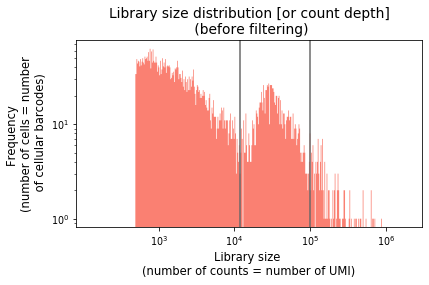

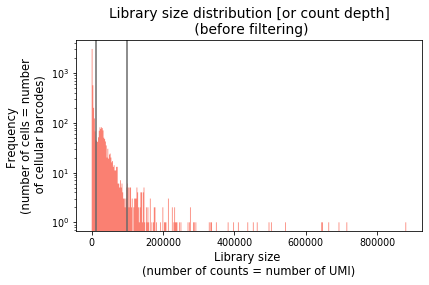

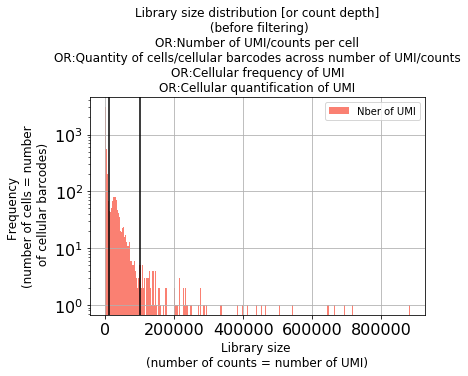

In [38]:
# https://krishnaswamylab.github.io/tutorial/load_filter_transform/
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html

scprep.plot.plot_library_size(df.transpose(), bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Library size \n(number of counts = number of UMI)', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Library size distribution [or count depth]\n (before filtering)', fontsize=8, filename=None, dpi=None, color='salmon')
plt.axvline(12000, color='dimgray')
plt.axvline(100000, color='dimgray')
plt.savefig('1_1.eps')

scprep.plot.plot_library_size(df.transpose(), bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Library size \n(number of counts = number of UMI)', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Library size distribution [or count depth]\n (before filtering)', fontsize=8, filename=None, dpi=None, color='salmon')
plt.axvline(12000, color='dimgray')
plt.axvline(100000, color='dimgray')
plt.savefig('1_1bis.eps')

#plt.rcParams['figure.figsize']=(8,8) #rescale figures
nbUMIpercell.plot.hist(nbUMIpercell,bins=400,log=True, title='Library size distribution [or count depth]\n (before filtering)\nOR:Number of UMI/counts per cell\nOR:Quantity of cells/cellular barcodes across number of UMI/counts\nOR:Cellular frequency of UMI\nOR:Cellular quantification of UMI', fontsize=16, color='salmon', grid=True)
plt.xlabel('Library size \n(number of counts = number of UMI)', fontsize=12)
plt.ylabel('Frequency \n(number of cells = number\n of cellular barcodes)', fontsize=12)
plt.axvline(12000, color='k')
plt.axvline(100000, color='k')
plt.show()

* Number of Genes Expressed per Cell

In [7]:
# print("Number of genes expressed : ") df[i].count()

nbgenesexpressedpercell = pd.DataFrame(np.count_nonzero(df, axis=0), index = cellnames, columns =['Nber of genes expressed'])   # np.count_nonzero(df, axis=0)  or something like : print((df['AAACCCAAGACAACAT'] != 0).sum())
nbgenesexpressedpercell_list = nbgenesexpressedpercell['Nber of genes expressed'].tolist()
print("Number of genes expressed per cell : \n\n", nbgenesexpressedpercell)     # or : tabulate([nbgenesexpressedpercell], headers=cellnames)
# print(nbgenesexpressedpercell_list)

# nbgenesexpressedpercell.insert(0,cellnames)

Number of genes expressed per cell : 

                   Nber of genes expressed
AAACCCAAGAACTGAT                     5829
AAACCCAAGGGAGGGT                      915
AAACCCAAGTCACAGG                      748
AAACCCAAGTCGCCCA                      415
AAACCCACAGGTGTGA                     2643
...                                   ...
TTTGTTGCATAGCACT                     1058
TTTGTTGTCAGTGATC                      468
TTTGTTGTCCCAATAG                      833
TTTGTTGTCCTTCAGC                      438
TTTGTTGTCTTCCTAA                      327

[5223 rows x 1 columns]


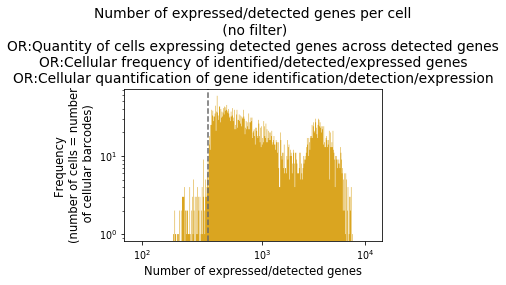

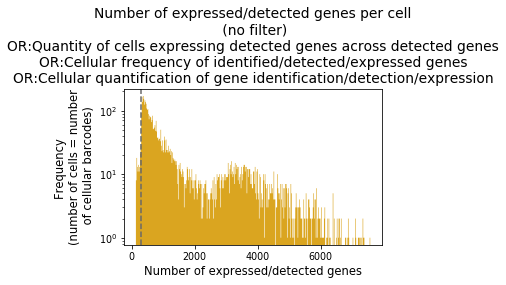

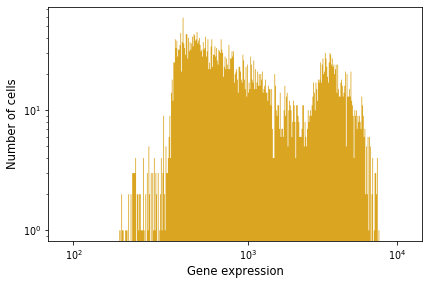

In [27]:
# https://krishnaswamylab.github.io/tutorial/load_filter_transform/
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html

scprep.plot.plot_library_size(nbgenesexpressedpercell, bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of expressed/detected genes', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Number of expressed/detected genes per cell\n (no filter)\nOR:Quantity of cells expressing detected genes across detected genes\nOR:Cellular frequency of identified/detected/expressed genes\nOR:Cellular quantification of gene identification/detection/expression', fontsize=8, filename=None, dpi=None, color='goldenrod')
plt.axvline(300, color='dimgray', linestyle='--')
plt.savefig('1_2.eps')

scprep.plot.plot_library_size(nbgenesexpressedpercell, bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of expressed/detected genes', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Number of expressed/detected genes per cell\n (no filter)\nOR:Quantity of cells expressing detected genes across detected genes\nOR:Cellular frequency of identified/detected/expressed genes\nOR:Cellular quantification of gene identification/detection/expression', fontsize=8, filename=None, dpi=None, color='goldenrod')
plt.axvline(300, color='dimgray', linestyle='--')
plt.savefig('1_2bis.eps')

##scprep.plot.plot_gene_set_expression(nbgenesexpressedpercell, bins=400, log=True, fontsize=8, filename=None, dpi=None, color='goldenrod')

#plt.rcParams['figure.figsize']=(8,8) #rescale figures
#nbgenesexpressedpercell.plot.hist(nbgenesexpressedpercell,bins=400,log=True, title='Number of expressed/detected genes per cell\n (no filter)\nOR:Quantity of cells expressing detected genes across detected genes\nOR:Cellular frequency of identified/detected/expressed genes\nOR:Cellular quantification of gene identification/detection/expression', fontsize=16, color='goldenrod', grid=False)
#plt.xlabel('Number of expressed/detected genes', fontsize=12)
#plt.ylabel('Frequency \n(number of cells = number\n of cellular barcodes)', fontsize=12)
#plt.axvline(300, color='k', linestyle='--')
#plt.show()

* Number of Unique Molecular Identifiers (UMI) per Gene

In [9]:
nbUMIpergenes = pd.DataFrame(df.sum(axis = 1), index = genenames, columns =['Nber of UMI'])
nbUMIpergenes_list = nbUMIpergenes['Nber of UMI'].tolist()
print("Number of UMI per gene : \n\n", nbUMIpergenes)
# print(nbUMIpergenes_list)

Number of UMI per gene : 

          Nber of UMI
CG15322           82
CG33217         1121
Vps11           1694
RpL10         258062
G9a             4681
...              ...
Pino            2355
CG4629            27
S               3611
CG2839            27
Nnf1b            885

[9506 rows x 1 columns]


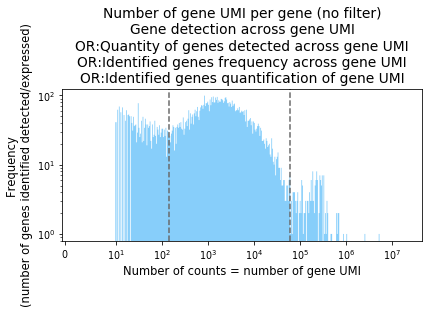

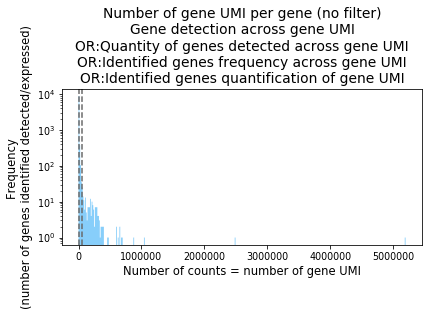

In [10]:
# https://krishnaswamylab.github.io/tutorial/load_filter_transform/
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html

#TOTAL GENE EXPRESSION (ACROSS CELLS) FOR EACH GENE
scprep.plot.plot_library_size(nbUMIpergenes, bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of counts = number of gene UMI', ylabel='Frequency \n(number of genes identified detected/expressed)', title='Number of gene UMI per gene (no filter)\nGene detection across gene UMI\nOR:Quantity of genes detected across gene UMI\nOR:Identified genes frequency across gene UMI\nOR:Identified genes quantification of gene UMI', fontsize=8, filename=None, dpi=None, color='lightskyblue')
plt.axvline(140, color='dimgray', linestyle='--')
plt.axvline(60000, color='dimgray', linestyle='--')
plt.savefig('1_3.eps')

scprep.plot.plot_library_size(nbUMIpergenes, bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of counts = number of gene UMI', ylabel='Frequency \n(number of genes identified detected/expressed)', title='Number of gene UMI per gene (no filter)\nGene detection across gene UMI\nOR:Quantity of genes detected across gene UMI\nOR:Identified genes frequency across gene UMI\nOR:Identified genes quantification of gene UMI', fontsize=8, filename=None, dpi=None, color='lightskyblue')
plt.axvline(140, color='dimgray', linestyle='--')
plt.axvline(60000, color='dimgray', linestyle='--')
plt.savefig('1_3bis.eps')

#plt.rcParams['figure.figsize']=(8,8) #rescale figures
#nbUMIpergenes.plot.hist(nbUMIpergenes,bins=400,log=True, title='Number of gene UMI per gene (no filter)\nGene detection across gene UMI\nOR:Quantity of genes detected across gene UMI\nOR:Identified genes frequency across gene UMI\nOR:Identified genes quantification of gene UMI', fontsize=16, color='lightskyblue', grid=False)
#plt.xlabel('Number of counts = number of gene UMI', fontsize=12)
#plt.ylabel('Frequency \n(number of genes identified detected/expressed)', fontsize=12)
#plt.axvline(140, color='dimgray', linestyle='--')
#plt.axvline(60000, color='dimgray', linestyle='--')
#plt.show()

* Number of Cells Expressing Each Gene per Gene

In [11]:
#print("Number of cells expressing gene expressed : ") df[i].count()
# nbcellsexpressinggene = nbcellsexpressinggene.tolist()

nbcellsexpressinggene = pd.DataFrame(np.count_nonzero(df, axis=1), index = genenames, columns =['Nb cells expressing gene'])   # np.count_nonzero(df, axis=1)  or something like : print((df['AAACCCAAGACAACAT'] != 0).sum())
nbcellsexpressinggene_list = nbcellsexpressinggene['Nb cells expressing gene'].tolist()
print("Number of cells expressing gene : \n\n", nbcellsexpressinggene)     # or : tabulate([nbcellsexpressinggene], headers=genenames)
# print(nbcellsexpressinggene_list)

#nbcellsexpressinggene.insert(0,genenames)

Number of cells expressing gene : 

          Nb cells expressing gene
CG15322                        19
CG33217                       714
Vps11                         875
RpL10                        4879
G9a                          1466
...                           ...
Pino                         1026
CG4629                         11
S                            1240
CG2839                         22
Nnf1b                         523

[9506 rows x 1 columns]


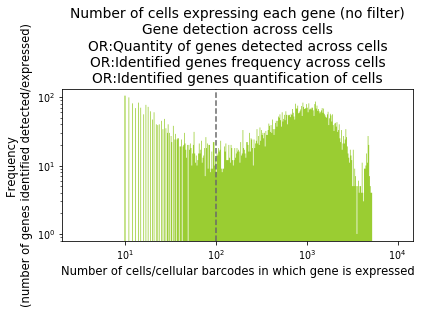

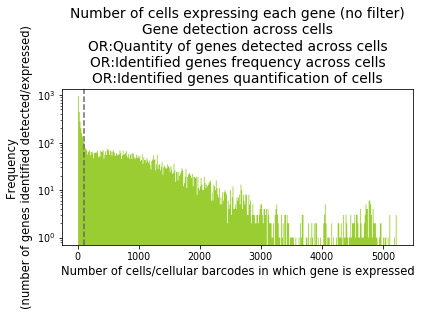

In [12]:
# https://krishnaswamylab.github.io/tutorial/load_filter_transform/
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html

scprep.plot.plot_library_size(nbcellsexpressinggene, bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of cells/cellular barcodes in which gene is expressed', ylabel='Frequency \n(number of genes identified detected/expressed)', title='Number of cells expressing each gene (no filter)\nGene detection across cells\nOR:Quantity of genes detected across cells\nOR:Identified genes frequency across cells\nOR:Identified genes quantification of cells', fontsize=8, filename=None, dpi=None, color='yellowgreen')
plt.axvline(100, color='dimgray', linestyle='--')
plt.savefig('1_4.eps')

scprep.plot.plot_library_size(nbcellsexpressinggene, bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of cells/cellular barcodes in which gene is expressed', ylabel='Frequency \n(number of genes identified detected/expressed)', title='Number of cells expressing each gene (no filter)\nGene detection across cells\nOR:Quantity of genes detected across cells\nOR:Identified genes frequency across cells\nOR:Identified genes quantification of cells', fontsize=8, filename=None, dpi=None, color='yellowgreen')
plt.axvline(100, color='dimgray', linestyle='--')
plt.savefig('1_4bis.eps')

#plt.rcParams['figure.figsize']=(8,8) #rescale figures
#nbcellsexpressinggene.plot.hist(nbcellsexpressinggene,bins=400,log=True, title='Number of cells expressing each gene (no filter)\nGene detection across cells\nOR:Quantity of genes detected across cells\nOR:Identified genes frequency across cells\nOR:Identified genes quantification of cells', fontsize=16, color='yellowgreen', grid=False)
#plt.xlabel('Number of cells/cellular barcodes in which gene is expressed', fontsize=12)
#plt.ylabel('Frequency \n(number of genes identified detected/expressed)', fontsize=12)
#plt.axvline(300, color='k', linestyle='--')
#plt.show()

* Data Description

In [13]:
# Per Cell
print(df.describe(include='all'))

#Per Gene
dftranspo = df.transpose()
print(dftranspo.describe(include='all'))

       AAACCCAAGAACTGAT  AAACCCAAGGGAGGGT  AAACCCAAGTCACAGG  AAACCCAAGTCGCCCA  \
count       9506.000000       9506.000000       9506.000000       9506.000000   
mean          13.895750          0.251420          0.415106          0.083421   
std          161.748948          2.388626         10.682132          0.604459   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            1.000000          0.000000          0.000000          0.000000   
75%            6.000000          0.000000          0.000000          0.000000   
max        13457.000000        198.000000        971.000000         26.000000   

       AAACCCACAGGTGTGA  AAACCCACATAATCCG  AAACCCACATGTTACG  AAACCCAGTTGCGTAT  \
count       9506.000000       9506.000000       9506.000000       9506.000000   
mean           1.114033          0.105618          0.080581          3.689459   
std           12.928348    

### 2) Keep only cells containing between 12 000 and 100 000 UMI

In [14]:
'''Version 1
filtering = []
for i in range(len(cellnames)):
    if nbUMIpercell.iloc[i, 0]>12000 and nbUMIpercell.iloc[i, 0]<100000:    # https://stackoverflow.com/questions/2485466/pythons-equivalent-of-logical-and-in-an-if-statement  # https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
        filtering.append([cellnames[i], nbUMIpercell.iloc[i,0]])
#print("TESTING")   #print(cellnames[2])    #print(nbUMIpercell['Nber of UMI'][2])  #print(nbUMIpercell.iloc[2, 0])     #print(nbUMIpercell.iloc[:, 0])     #print(nbUMIpercell.iloc[2,:], "\n")     #print("TESTING")   #print(filtering)   #print(filtering[0])    #print(filtering.iloc[:, 0])
filterdf1 = pd.DataFrame(filtering, columns =['Cell name', 'Nb of UMI'])
filterdf1 = filterdf1.set_index('Cell name')
print("Filter -> Keep cells containing more than 12000 UMI and less than 100000 UMI : \n\n", filterdf1)     # or : tabulate([filterdf1['Nb of UMI']], headers=filterdf1.index.tolist())   # or (if before): tabulate([filterdf1.iloc[:,1]], headers=filterdf1.iloc[:,0])
'''

filterdf1 = nbUMIpercell.loc[(nbUMIpercell.iloc[:,0] >= 12000) & (nbUMIpercell.iloc[:,0] <= 100000),:]
print("Cells containing more than 12000 UMI and less than 100000 UMI : ", filterdf1.index.tolist(), "\n\n", filterdf1)

# https://stackoverflow.com/questions/40636514/selecting-pandas-dataframe-column-by-list    # https://datatofish.com/convert-pandas-dataframe-to-list/  # https://stackoverflow.com/questions/30101369/how-can-i-print-out-just-the-index-of-a-pandas-dataframe
filtereddf1 = df[df.columns.intersection(filterdf1.index.tolist())]     #For more details :     #print(filterdf1.index.tolist())    #print(df.columns.values)   #print(df.columns.intersection(filterdf1.index.tolist()))
print("Filtered dataframe : \n\n", filtereddf1)

###filtereddf1_othermethod=scprep.filter.filter_library_size(df.transpose(), cutoff=[12000, 100000], keep_cells='between')
###print(filtereddf1_othermethod)

Cells containing more than 12000 UMI and less than 100000 UMI :  ['AAACCCAGTTGCGTAT', 'AAACGAACAGGCTTGC', 'AAACGAATCACATTGG', 'AAACGCTGTTGGGACA', 'AAAGAACTCTATCACT', 'AAAGGATAGGATGGCT', 'AAAGTGAGTCTTTCAT', 'AAAGTGAGTGGTCCCA', 'AAATGGACACGTGAGA', 'AACAAAGTCTTCGTAT', 'AACAACCAGCAATTCC', 'AACAAGAAGAGTATAC', 'AACAAGAGTTATTCTC', 'AACCATGAGTACTGTC', 'AACCATGGTGGCGTAA', 'AACCCAAAGCTCCGAC', 'AACCCAAAGTAGGGTC', 'AACCTGAAGGTACATA', 'AACCTTTTCATGCCGG', 'AACGAAAAGGCGACAT', 'AAGACTCCAGTAACCT', 'AAGATAGGTATTGCCA', 'AAGCCATAGCCAAGTG', 'AAGCCATTCGCGAAGA', 'AAGGAATAGGTATAGT', 'AAGGAATGTCTTAGTG', 'AAGGAATTCCGCCTAT', 'AAGGAATTCTTGGATG', 'AAGGTAACACCAAAGG', 'AAGGTAATCCAAATGC', 'AAGTACCCATGGCGCT', 'AAGTACCTCCTACCAC', 'AAGTCGTAGCCATGCC', 'AAGTTCGTCCACGGAC', 'AATAGAGCACCAAATC', 'AATAGAGCACCACTGG', 'AATAGAGGTATCTCTT', 'AATAGAGTCTACGCGG', 'AATCACGCAATGTCAC', 'AATCACGCATGACGAG', 'AATCACGTCGACCACG', 'AATCGACAGATTACCC', 'AATGAAGAGGTGCCAA', 'AATGCCAAGTCAGCGA', 'AATGCCACAAGAGAGA', 'AATGCCACAGCACCCA', 'AATGCCAGTCTAC

### 3) Eliminate cells containing a high fraction of  mitochondrial genes (>30% of UMI in the cell are mitochondrial).

In [15]:
mitodf = pd.read_table('list_mitochondrial_genes.txt', sep=';')
print('Mitochondrial genes dataframe:\n', mitodf, '\n')

#mitolist1 = open('list_mitochondrial_genes.txt', 'r').readlines()
#mitolist2 = [line.split(',') for line in open("list_mitochondrial_genes.txt")]
#mitolist3 = [word.split(';') for word in open("list_mitochondrial_genes.txt").readlines()]
#print(mitolist1)
#print(mitolist2)
#print(mitolist3, "\n")

#import string
#words = mitodf.split()
#table = str.maketrans('', '', string.punctuation)
#stripped = [w.translate(table) for w in words]
#print(stripped[:100])

#filename = 'list_mitochondrial_genes.txt'  # https://machinelearningmastery.com/clean-text-machine-learning-python/
#file = open(filename, 'rt')
#text = file.read()
#file.close()
#print(text)
#p=list(text)
#print('aaa', p)
#p=list(text. split(";"))
#print('aaa', p)
#mitolist4 = mitolist3.replace('"', '')     # https://www.journaldev.com/23674/python-remove-character-from-string
#mitolist4 = mitolist3.translate({ord('"'): None})

#mitolist6=mitolist1+mitolist4+mitolist5
#mitolist4 = str(mitolist3).replace('"', '').replace("'", '').replace('[', '').replace(']', '')     # https://stackoverflow.com/questions/42183479/i-want-to-replace-single-quotes-with-double-quotes-in-a-list
#print(mitolist4)
#mitolist5 = list(mitolist4.split(", "))     # https://www.geeksforgeeks.org/python-program-convert-string-list/
#print(mitolist5)

mitolist = list(str(open('list_mitochondrial_genes.txt', 'r').readlines()).replace('"', '').replace("'", '').replace('[', '').replace(']', '').replace('\\n', '').split(";"))       # https://stackoverflow.com/questions/42183479/i-want-to-replace-single-quotes-with-double-quotes-in-a-list       # https://www.geeksforgeeks.org/python-program-convert-string-list/
print('Mitochondrial genes list:\n', mitolist)

Mitochondrial genes dataframe:
 Empty DataFrame
Columns: [MTPAP, mTerf3, COX5B, Mtpalpha, mTTF, COX4, COX7A, mtTFB2, COX5A, mTerf5, COX7C, mtDNA-helicase, ND2, trnC, trnY, COX1, COX2, ATP8, ATP6, COX3, ND3, trnR, ND5, ND4L, ND6, CYTB, ND1, trnL2, lrRNA, trnV, srRNA, mtRNApol, ND4, Mtch, COX8, COX6B]
Index: []

[0 rows x 36 columns] 

Mitochondrial genes list:
 ['MTPAP', 'mTerf3', 'COX5B', 'Mtpalpha', 'mTTF', 'COX4', 'COX7A', 'mtTFB2', 'COX5A', 'mTerf5', 'COX7C', 'mtDNA-helicase', 'ND2', 'trnC', 'trnY', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'trnR', 'ND5', 'ND4L', 'ND6', 'CYTB', 'ND1', 'trnL2', 'lrRNA', 'trnV', 'srRNA', 'mtRNApol', 'ND4', 'Mtch', 'COX8', 'COX6B']


In [16]:
percentUMImitotot = []
for i in df.columns:   #or (filtereddf1.columns)
    countnbUMImitoincell = 0
    for j in df.index:
        if j in mitolist: 
            countnbUMImitoincell = countnbUMImitoincell + df.loc[j, i]
    percentUMImitotot.append(countnbUMImitoincell/nbUMIpercell.loc[i, 'Nber of UMI'])
print(percentUMImitotot, '\n')
percentUMImitopercelltot = pd.DataFrame(percentUMImitotot, index = nbUMIpercell.index, columns =['Proportion of mitochondrial UMI']) 
print(percentUMImitopercelltot)

[0.0401308169244396, 0.024686192468619247, 0.00963000506842372, 0.044136191677175286, 0.06808309726156751, 0.0846613545816733, 0.06135770234986945, 0.07458941605839416, 0.08038352193544791, 0.033336251805804844, 0.03917910447761194, 0.06467661691542288, 0.03747313112013375, 0.006220546654099906, 0.0680421172453045, 0.037641386983126274, 0.10214655810510732, 0.13183972425678586, 0.13566739606126915, 0.06548672566371681, 0.05330661322645291, 0.023622047244094488, 0.23127035830618892, 0.25863392171910976, 0.4367704280155642, 0.16318719554627698, 0.053385416666666664, 0.050203527815468114, 0.05144404332129964, 0.06673349563224974, 0.4231578947368421, 0.0502283105022831, 0.08960915157292659, 0.03231597845601436, 0.07222222222222222, 0.07171314741035857, 0.10048622366288493, 0.0029498525073746312, 0.02748091603053435, 0.017580872011251757, 0.05411294715816234, 0.06773488710852149, 0.01348314606741573, 0.011920529801324504, 0.10947930574098798, 0.04878048780487805, 0.03707865168539326, 0.0684

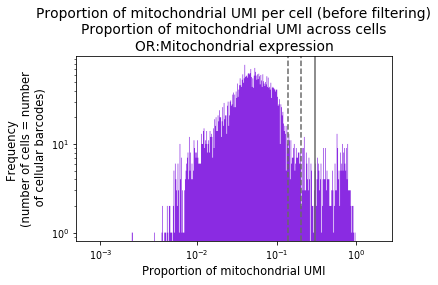

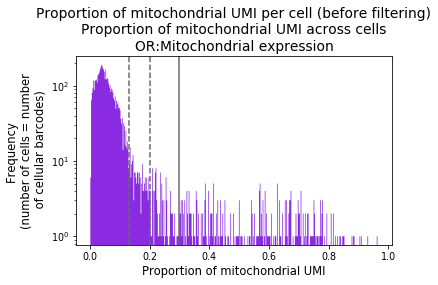

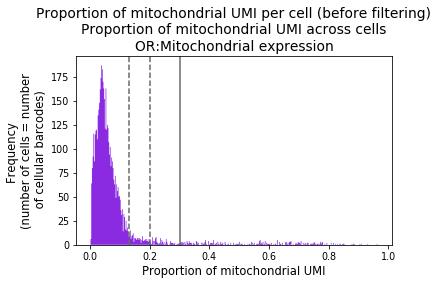

In [17]:
# https://krishnaswamylab.github.io/tutorial/load_filter_transform/
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html

scprep.plot.plot_library_size(percentUMImitopercelltot, bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Proportion of mitochondrial UMI', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Proportion of mitochondrial UMI per cell (before filtering)\nProportion of mitochondrial UMI across cells\nOR:Mitochondrial expression', fontsize=8, filename=None, dpi=None, color='blueviolet')
plt.axvline(0.14, color='dimgray', linestyle='--')
plt.axvline(0.2, color='dimgray', linestyle='--')
plt.axvline(0.3, color='dimgray')
##ax.axvline(np.percentile(percentUMImitopercelltot['Proportion of mitochondrial UMI'], 95))
plt.savefig('1_5.eps')

scprep.plot.plot_library_size(percentUMImitopercelltot, bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Proportion of mitochondrial UMI', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Proportion of mitochondrial UMI per cell (before filtering)\nProportion of mitochondrial UMI across cells\nOR:Mitochondrial expression', fontsize=8, filename=None, dpi=None, color='blueviolet')
plt.axvline(0.13, color='dimgray', linestyle='--')
plt.axvline(0.2, color='dimgray', linestyle='--')
plt.axvline(0.3, color='dimgray')
##ax.axvline(np.percentile(percentUMImitopercelltot['Proportion of mitochondrial UMI'], 95))
plt.savefig('1_5bis.eps')

scprep.plot.plot_library_size(percentUMImitopercelltot, bins=400, log=False, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Proportion of mitochondrial UMI', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Proportion of mitochondrial UMI per cell (before filtering)\nProportion of mitochondrial UMI across cells\nOR:Mitochondrial expression', fontsize=8, filename=None, dpi=None, color='blueviolet')
plt.axvline(0.13, color='dimgray', linestyle='--')
plt.axvline(0.2, color='dimgray', linestyle='--')
plt.axvline(0.3, color='dimgray')
##ax.axvline(np.percentile(percentUMImitopercelltot['Proportion of mitochondrial UMI'], 95))
plt.savefig('1_5bis.eps')

#plt.rcParams['figure.figsize']=(8,8) #rescale figures
#percentUMImitopercelltot.plot.hist(percentUMImitopercelltot['Proportion of mitochondrial UMI'],bins=400,log=True, title='Proportion of mitochondrial UMI per cell (before filtering)\nProportion of mitochondrial UMI across cells\nOR:Mitochondrial expression', fontsize=16, color='blueviolet', grid=False)
#plt.xlabel('Proportion of mitochondrial UMI', fontsize=12)
#plt.ylabel('Frequency \n(number of cells = number\n of cellular barcodes)', fontsize=12)
##ax.axvline(np.percentile(percentUMImitopercelltot['Proportion of mitochondrial UMI'], 95))
#plt.axvline(0.2, color='dimgray', linestyle='--')
#plt.axvline(0.3, color='dimgray')
#plt.show()

In [18]:
percentUMImito = []
for i in filterdf1.index:   #or (filtereddf1.columns)
    countnbUMImitoincell = 0
    for j in filtereddf1.index:
        if j in mitolist: #For more details :     #print(filterdf1.index.tolist())    #print(df.columns.values)   #print(df.columns.intersection(filterdf1.index.tolist()))
            countnbUMImitoincell = countnbUMImitoincell + filtereddf1.loc[j, i]
    percentUMImito.append(countnbUMImitoincell/filterdf1.loc[i, 'Nber of UMI'])
# print(percentUMImito, '\n')
percentUMImitopercell = pd.DataFrame(percentUMImito, index = filterdf1.index, columns =['Proportion of mitochondrial UMI']) 
print(percentUMImitopercell)

                  Proportion of mitochondrial UMI
AAACCCAGTTGCGTAT                         0.074589
AAACGAACAGGCTTGC                         0.080384
AAACGAATCACATTGG                         0.033336
AAACGCTGTTGGGACA                         0.037473
AAAGAACTCTATCACT                         0.068042
...                                           ...
TTTCCTCTCAATCAGC                         0.056988
TTTCCTCTCATGCAGT                         0.032011
TTTCGATAGAAGGCTC                         0.049621
TTTGGAGTCGGCCCAA                         0.033248
TTTGGTTAGGGATCTG                         0.040158

[1100 rows x 1 columns]


In [19]:
filterdf1['Proportion of mitochondrial UMI'] = percentUMImito
print("Proportion of mitochondrial UMI in cells left after first filtration : \n\n", filterdf1)
# print(filterdf1['Proportion of mitochondrial UMI'])

Proportion of mitochondrial UMI in cells left after first filtration : 

                   Nber of UMI  Proportion of mitochondrial UMI
AAACCCAGTTGCGTAT        35072                         0.074589
AAACGAACAGGCTTGC        17939                         0.080384
AAACGAATCACATTGG        45686                         0.033336
AAACGCTGTTGGGACA        41870                         0.037473
AAAGAACTCTATCACT        70280                         0.068042
...                       ...                              ...
TTTCCTCTCAATCAGC        31182                         0.056988
TTTCCTCTCATGCAGT        48671                         0.032011
TTTCGATAGAAGGCTC        51752                         0.049621
TTTGGAGTCGGCCCAA        25746                         0.033248
TTTGGTTAGGGATCTG        62952                         0.040158

[1100 rows x 2 columns]


/Users/fairouz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
filterdf2 = percentUMImitopercell.loc[(filterdf1.iloc[:,1] <= 0.30),:]
print("Cells containing less than 30% of mitochondrial UMI : ", filterdf2.index.tolist(), "\n\n", filterdf2)

# https://stackoverflow.com/questions/40636514/selecting-pandas-dataframe-column-by-list    # https://datatofish.com/convert-pandas-dataframe-to-list/  # https://stackoverflow.com/questions/30101369/how-can-i-print-out-just-the-index-of-a-pandas-dataframe
filtereddf2 = filtereddf1[filtereddf1.columns.intersection(filterdf2.index.tolist())]     #For more details :     #print(filterdf1.index.tolist())    #print(df.columns.values)   #print(df.columns.intersection(filterdf1.index.tolist()))
print("Filtered dataframe : \n\n", filtereddf2)

Cells containing less than 30% of mitochondrial UMI :  ['AAACCCAGTTGCGTAT', 'AAACGAACAGGCTTGC', 'AAACGAATCACATTGG', 'AAACGCTGTTGGGACA', 'AAAGAACTCTATCACT', 'AAAGGATAGGATGGCT', 'AAAGTGAGTCTTTCAT', 'AAAGTGAGTGGTCCCA', 'AAATGGACACGTGAGA', 'AACAAAGTCTTCGTAT', 'AACAACCAGCAATTCC', 'AACAAGAAGAGTATAC', 'AACAAGAGTTATTCTC', 'AACCATGAGTACTGTC', 'AACCATGGTGGCGTAA', 'AACCCAAAGCTCCGAC', 'AACCCAAAGTAGGGTC', 'AACCTGAAGGTACATA', 'AACCTTTTCATGCCGG', 'AACGAAAAGGCGACAT', 'AAGACTCCAGTAACCT', 'AAGATAGGTATTGCCA', 'AAGCCATAGCCAAGTG', 'AAGCCATTCGCGAAGA', 'AAGGAATAGGTATAGT', 'AAGGAATGTCTTAGTG', 'AAGGAATTCCGCCTAT', 'AAGGAATTCTTGGATG', 'AAGGTAACACCAAAGG', 'AAGGTAATCCAAATGC', 'AAGTACCCATGGCGCT', 'AAGTACCTCCTACCAC', 'AAGTCGTAGCCATGCC', 'AAGTTCGTCCACGGAC', 'AATAGAGCACCAAATC', 'AATAGAGCACCACTGG', 'AATAGAGGTATCTCTT', 'AATAGAGTCTACGCGG', 'AATCACGCAATGTCAC', 'AATCACGCATGACGAG', 'AATCACGTCGACCACG', 'AATCGACAGATTACCC', 'AATGAAGAGGTGCCAA', 'AATGCCAAGTCAGCGA', 'AATGCCACAAGAGAGA', 'AATGCCACAGCACCCA', 'AATGCCAGTCTACAGT', 'AAT

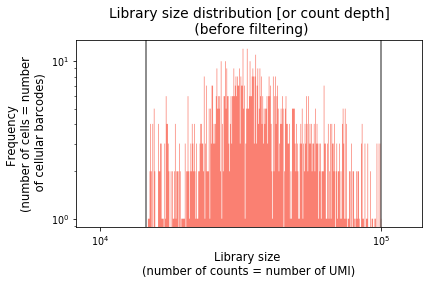

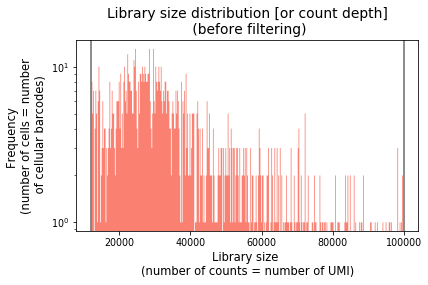

In [21]:
scprep.plot.plot_library_size(filtereddf2.transpose(), bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Library size \n(number of counts = number of UMI)', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Library size distribution [or count depth]\n (before filtering)', fontsize=8, filename=None, dpi=None, color='salmon')
plt.axvline(12000, color='dimgray')
plt.axvline(100000, color='dimgray')
plt.savefig('2_1.eps')

scprep.plot.plot_library_size(filtereddf2.transpose(), bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Library size \n(number of counts = number of UMI)', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Library size distribution [or count depth]\n (before filtering)', fontsize=8, filename=None, dpi=None, color='salmon')
plt.axvline(12000, color='dimgray')
plt.axvline(100000, color='dimgray')
plt.savefig('2_1bis.eps')

#scprep.plot.plot_library_size(test, bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Library size \n(number of counts = number of UMI)', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Library size distribution [or count depth]\n (before filtering)', fontsize=8, filename=None, dpi=None, color='salmon')
#scprep.plot.plot_library_size(test, bins=400, log='y', cutoff=[12000, 100000], percentile=None, ax=None, figsize=None, xlabel='Library size \n(number of counts = number of UMI)', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Library size distribution [or count depth]\n (before filtering)', fontsize=8, filename=None, dpi=None, color='salmon')

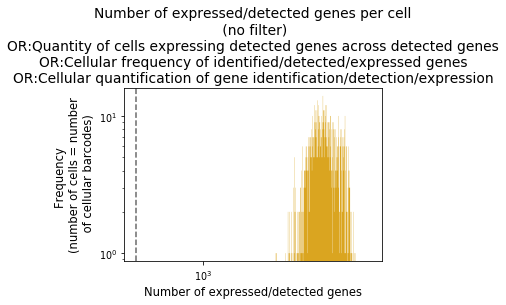

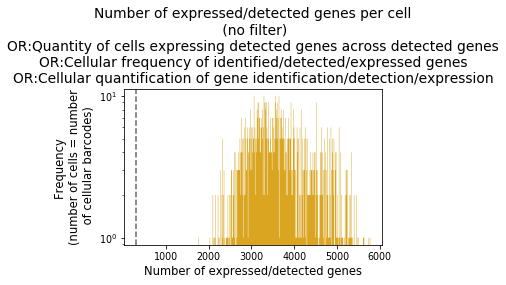

In [28]:
# https://gist.github.com/mannsi/be2c2365e1b4036137f392d97846b318

scprep.plot.plot_library_size(nbgenesexpressedpercell[nbgenesexpressedpercell.index.isin(filtereddf2.columns)], bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of expressed/detected genes', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Number of expressed/detected genes per cell\n (no filter)\nOR:Quantity of cells expressing detected genes across detected genes\nOR:Cellular frequency of identified/detected/expressed genes\nOR:Cellular quantification of gene identification/detection/expression', fontsize=8, filename=None, dpi=None, color='goldenrod')
plt.axvline(300, color='dimgray', linestyle='--')
plt.savefig('2_2.eps')

scprep.plot.plot_library_size(nbgenesexpressedpercell[nbgenesexpressedpercell.index.isin(filtereddf2.columns)], bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of expressed/detected genes', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Number of expressed/detected genes per cell\n (no filter)\nOR:Quantity of cells expressing detected genes across detected genes\nOR:Cellular frequency of identified/detected/expressed genes\nOR:Cellular quantification of gene identification/detection/expression', fontsize=8, filename=None, dpi=None, color='goldenrod')
plt.axvline(300, color='dimgray', linestyle='--')
plt.savefig('2_2bis.eps')

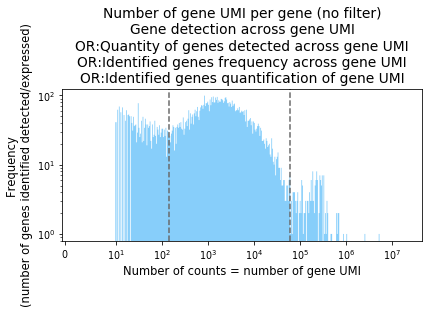

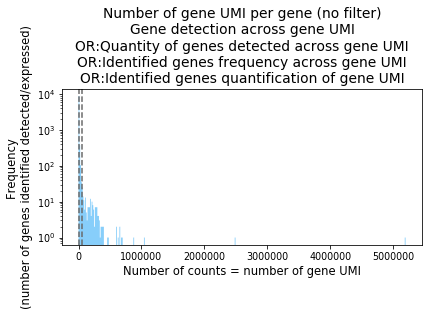

In [29]:
#TOTAL GENE EXPRESSION (ACROSS CELLS) FOR EACH GENE
scprep.plot.plot_library_size(nbUMIpergenes[nbUMIpergenes.index.isin(filtereddf2.index)], bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of counts = number of gene UMI', ylabel='Frequency \n(number of genes identified detected/expressed)', title='Number of gene UMI per gene (no filter)\nGene detection across gene UMI\nOR:Quantity of genes detected across gene UMI\nOR:Identified genes frequency across gene UMI\nOR:Identified genes quantification of gene UMI', fontsize=8, filename=None, dpi=None, color='lightskyblue')
plt.axvline(140, color='dimgray', linestyle='--')
plt.axvline(60000, color='dimgray', linestyle='--')
plt.savefig('1_3.eps')

scprep.plot.plot_library_size(nbUMIpergenes[nbUMIpergenes.index.isin(filtereddf2.index)], bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of counts = number of gene UMI', ylabel='Frequency \n(number of genes identified detected/expressed)', title='Number of gene UMI per gene (no filter)\nGene detection across gene UMI\nOR:Quantity of genes detected across gene UMI\nOR:Identified genes frequency across gene UMI\nOR:Identified genes quantification of gene UMI', fontsize=8, filename=None, dpi=None, color='lightskyblue')
plt.axvline(140, color='dimgray', linestyle='--')
plt.axvline(60000, color='dimgray', linestyle='--')
plt.savefig('1_3bis.eps')

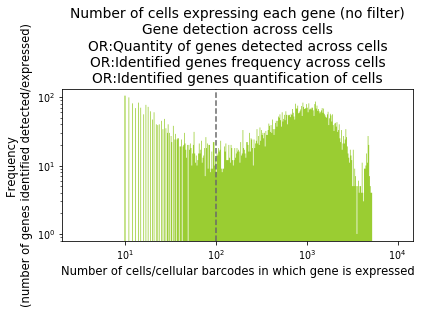

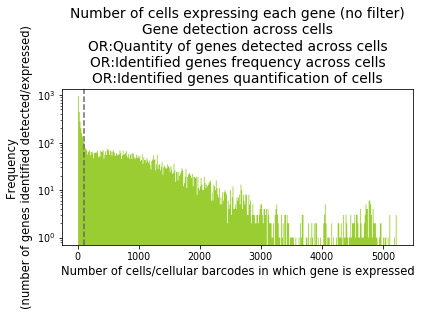

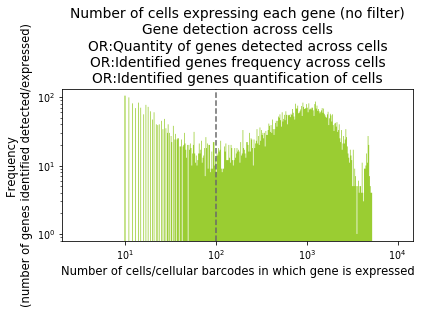

In [31]:
scprep.plot.plot_library_size(nbcellsexpressinggene[nbcellsexpressinggene.index.isin(filtereddf2.index)], bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of cells/cellular barcodes in which gene is expressed', ylabel='Frequency \n(number of genes identified detected/expressed)', title='Number of cells expressing each gene (no filter)\nGene detection across cells\nOR:Quantity of genes detected across cells\nOR:Identified genes frequency across cells\nOR:Identified genes quantification of cells', fontsize=8, filename=None, dpi=None, color='yellowgreen')
plt.axvline(100, color='dimgray', linestyle='--')
plt.savefig('1_4.eps')

scprep.plot.plot_library_size(nbcellsexpressinggene[nbcellsexpressinggene.index.isin(filtereddf2.index)], bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Number of cells/cellular barcodes in which gene is expressed', ylabel='Frequency \n(number of genes identified detected/expressed)', title='Number of cells expressing each gene (no filter)\nGene detection across cells\nOR:Quantity of genes detected across cells\nOR:Identified genes frequency across cells\nOR:Identified genes quantification of cells', fontsize=8, filename=None, dpi=None, color='yellowgreen')
plt.axvline(100, color='dimgray', linestyle='--')
plt.savefig('1_4bis.eps')

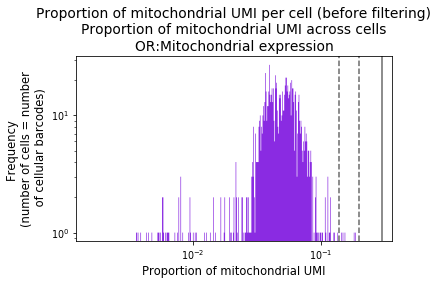

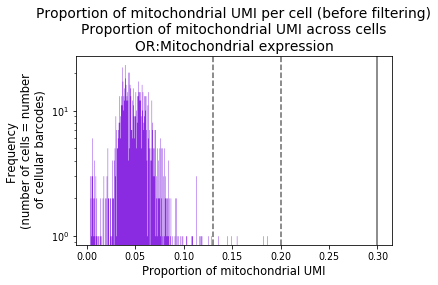

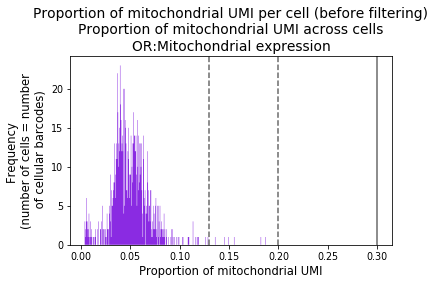

In [37]:
scprep.plot.plot_library_size(percentUMImitopercell[percentUMImitopercell.index.isin(filtereddf2.columns)], bins=400, log=True, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Proportion of mitochondrial UMI', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Proportion of mitochondrial UMI per cell (before filtering)\nProportion of mitochondrial UMI across cells\nOR:Mitochondrial expression', fontsize=8, filename=None, dpi=None, color='blueviolet')
plt.axvline(0.14, color='dimgray', linestyle='--')
plt.axvline(0.2, color='dimgray', linestyle='--')
plt.axvline(0.3, color='dimgray')
##ax.axvline(np.percentile(percentUMImitopercelltot['Proportion of mitochondrial UMI'], 95))
plt.savefig('1_5.eps')

scprep.plot.plot_library_size(percentUMImitopercell[percentUMImitopercell.index.isin(filtereddf2.columns)], bins=400, log='y', cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Proportion of mitochondrial UMI', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Proportion of mitochondrial UMI per cell (before filtering)\nProportion of mitochondrial UMI across cells\nOR:Mitochondrial expression', fontsize=8, filename=None, dpi=None, color='blueviolet')
plt.axvline(0.13, color='dimgray', linestyle='--')
plt.axvline(0.2, color='dimgray', linestyle='--')
plt.axvline(0.3, color='dimgray')
##ax.axvline(np.percentile(percentUMImitopercelltot['Proportion of mitochondrial UMI'], 95))
plt.savefig('1_5bis.eps')

scprep.plot.plot_library_size(percentUMImitopercell[percentUMImitopercell.index.isin(filtereddf2.columns)], bins=400, log=False, cutoff=None, percentile=None, ax=None, figsize=None, xlabel='Proportion of mitochondrial UMI', ylabel='Frequency \n(number of cells = number\n of cellular barcodes)', title='Proportion of mitochondrial UMI per cell (before filtering)\nProportion of mitochondrial UMI across cells\nOR:Mitochondrial expression', fontsize=8, filename=None, dpi=None, color='blueviolet')
plt.axvline(0.13, color='dimgray', linestyle='--')
plt.axvline(0.2, color='dimgray', linestyle='--')
plt.axvline(0.3, color='dimgray')
##ax.axvline(np.percentile(percentUMImitopercelltot['Proportion of mitochondrial UMI'], 95))
plt.savefig('1_5bis.eps')

### 4) What is the median number of UMI per cell (noted M)? Use this number to normalise data : Xnormalised = ln (x / Nb UMI cell * M +1)

From this point forward, we will be working on the normalised data.

## Identification of epithelial cells
### 5) Calculate variation coefficients of each gène and identify the 1500 genes that are the most variable.

### 6) Do a PCA based on the 1500 variable genes.

#### a. Bonus : Analyse the first axes by enrichement (GO enrichement analysis)

#### b. Keep only a low number of axes (ex : 8)

### 7) Use multiple classification methods (choose an algorithm)
### Or 7 bis) (Harder alternative) Use PAGA to partition your data [Wolf et al. Genome Biology (2019) 20:59 https://doi.org/10.1186/s13059-019-1663-x]

### 8) Try to identify the cellular type of each group. To help you, specific markers of each type have been made available.

In [ ]:
celltypedf = pd.read_table('listes_genes.txt', sep=',')
print(celltypedf)

### 9) Represent your labelled data (UMAP or t-SNE)
![UMAP-example](UMAP.png)
<img src="UMAP.png"/>

In [ ]:
from umi_tools import UMIClusterer
clusterer = UMIClusterer(cluster_method="directional")
